<a href="https://colab.research.google.com/github/Jiaye2027/Movie-Recommendation-System/blob/main/ALS_Spark_Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar -xzf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark

import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ALS Movie Recommender") \
    .getOrCreate()

print("✅ Spark is ready")


✅ Spark is ready


Data Schema:
root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)


Rating Distribution:
+------+-------+
|rating|  count|
+------+-------+
|   0.5|  71844|
|   1.0| 151200|
|   1.5|  72359|
|   2.0| 322405|
|   2.5| 232788|
|   3.0| 970858|
|   3.5| 574019|
|   4.0|1278799|
|   4.5| 392911|
|   5.0| 688623|
+------+-------+



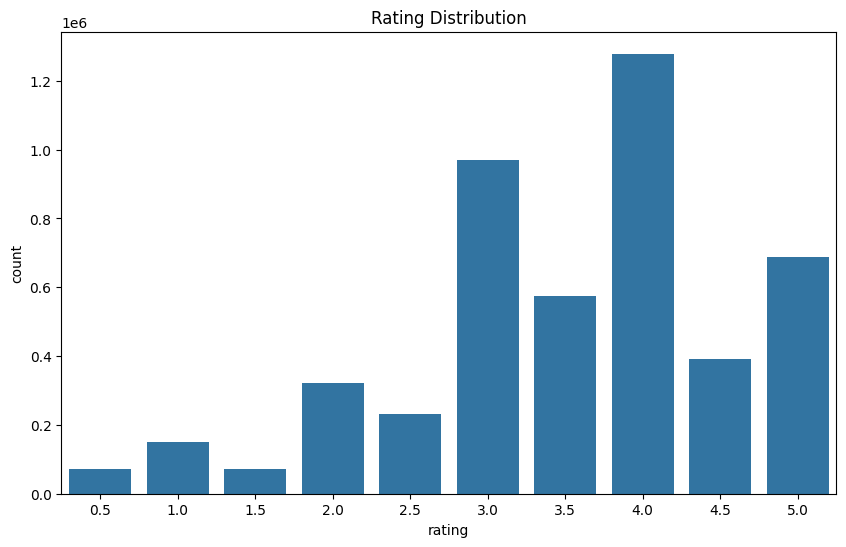

In [5]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load and Explore Data
ratings = spark.read.csv("/content/ratings.csv", header=True, inferSchema=True)
ratings_clean = ratings.select("userId", "movieId", "rating").na.drop()

print("Data Schema:")
ratings_clean.printSchema()

print("\nRating Distribution:")
ratings_clean.groupBy("rating").count().orderBy("rating").show()

# Plot rating distribution
pdf = ratings_clean.toPandas()
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=pdf)
plt.title('Rating Distribution')
plt.show()

# Data Preprocessing
train, test = ratings_clean.randomSplit([0.8, 0.2], seed=42)

In [7]:
# Model Configuration
als = ALS(
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True,
    implicitPrefs=False  # Changed to explicit feedback
)

# Hyperparameter Tuning
param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [5, 10, 15]) \
    .build()
    # .addGrid(als.regParam, [0.1, 0.5]) \
    # .addGrid(als.maxIter, [10, 15]) \


evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)

cv = CrossValidator(
    estimator=als,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=4
)

print("\nStarting hyperparameter tuning...")
cv_model = cv.fit(train)
best_model = cv_model.bestModel

print("\nBest Model Parameters:")
print(f"Rank: {best_model.rank}")
print(f"MaxIter: {best_model._java_obj.parent().getMaxIter()}")
print(f"RegParam: {best_model._java_obj.parent().getRegParam()}")

# Evaluation
predictions = best_model.transform(test)
rmse = evaluator.evaluate(predictions)
print(f"\nTest RMSE: {rmse:.4f}")



Starting hyperparameter tuning...

Best Model Parameters:
Rank: 15
MaxIter: 10
RegParam: 0.1

Test RMSE: 0.8262


In [8]:
# Generate Recommendations with Seen Items Filtered
def get_recommendations(model, user_id, num_recs=5):
    rated_movies = ratings_clean.filter(F.col("userId") == user_id) \
        .select("movieId").distinct()

    all_movies = ratings_clean.select("movieId").distinct()
    candidate_movies = all_movies.join(rated_movies, "movieId", "left_anti")

    user_df = spark.createDataFrame([(user_id,)]).toDF("userId")
    candidates = user_df.crossJoin(candidate_movies)

    preds = model.transform(candidates)
    return preds.orderBy(F.desc("prediction")).limit(num_recs)

user_id = 1
print(f"\nTop 10 Recommendations for User {user_id}:")
recommendations = get_recommendations(best_model, user_id)
recommendations.show()



Top 10 Recommendations for User 1:
+------+-------+----------+
|userId|movieId|prediction|
+------+-------+----------+
|     1| 174181|  6.510298|
|     1|  86087| 6.1236324|
|     1| 173939| 6.0455008|
|     1| 143571|  5.804464|
|     1| 145176|  5.798681|
+------+-------+----------+



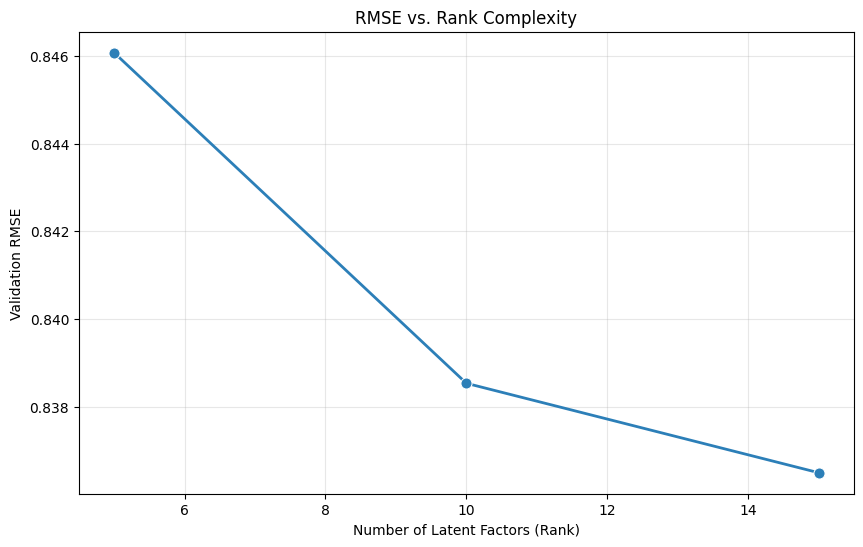

In [13]:
# Hyperparameter Tuning Visualization
results = []
for params, metric in zip(cv_model.getEstimatorParamMaps(), cv_model.avgMetrics):
    params_dict = {param.name: value for param, value in params.items()}
    results.append((params_dict['rank'],
                   metric))
                  #      params_dict['regParam'],
                  #  params_dict['maxIter'],

results_df = pd.DataFrame(results, columns=['rank', 'RMSE']) # 'regParam', 'maxIter',

plt.figure(figsize=(10, 6))
sns.lineplot(x='rank', y='RMSE', data=results_df, marker='o',
             linewidth=2, markersize=8, color='#2c7fb8')
plt.title('RMSE vs. Rank Complexity')
plt.xlabel('Number of Latent Factors (Rank)')
plt.ylabel('Validation RMSE')
plt.grid(True, alpha=0.3)
plt.show()

# spark.stop()
# print("\nSpark session stopped.")